In [9]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import resample


# Loading the data

In [6]:
#!gsutil -m cp -r gs://ff2s/preproc_data/preproc_photo/ ../preproc_data
#!gsutil -m cp -r gs://ff2s/preproc_data/preproc_sketch/ ../preproc_data

In [7]:
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in os.listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return np.asarray(data_list)

## Loading the photos as np.array

In [11]:
photo_path = os.path.join(os.getcwd(),"..","preproc_data","preproc_photo/")
photos = load_images(photo_path)

In [12]:
photos.shape

(2006, 256, 256, 3)

## Loading the sketches as np.array

In [13]:
sketch_path = os.path.join(os.getcwd(),"..","preproc_data","preproc_sketch/")
sketches = load_images(sketch_path)

In [14]:
sketches.shape

(2006, 256, 256, 3)

## Random sample of our data

In [15]:
#To get a subset of all images, for faster training during demonstration
photos_sample = resample(photos,
                         replace=False,
                         n_samples=100,
                         random_state=42) 

#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management. 
sketches_sample = resample(sketches, 
                           replace=False,     
                           n_samples=100,    
                           random_state=42)

## Plotting source images

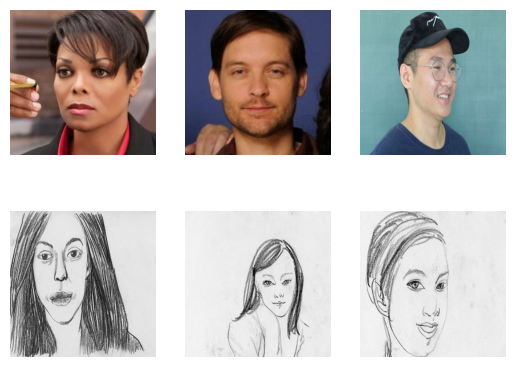

In [24]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(photos_sample[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(sketches_sample[i].astype('uint8'))
plt.show()

## Image preprocessing

We change input to values between -1 and 1 because the generator uses tanh 
activation in the output layer and tanh ranges between -1 and 1

In [25]:
# load image data
pair = [photos_sample, sketches_sample]

print('Loaded', pair[0].shape, pair[1].shape)

Loaded (100, 256, 256, 3) (100, 256, 256, 3)


In [26]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

pair_preprocessed = preprocess_data(pair)

In [30]:
!cd ..

In [38]:
from FF2S.cycleGAN_model import define_generator, define_discriminator, define_composite_model, train

# define input shape based on the loaded dataset
image_shape = pair_preprocessed[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

2022-12-01 16:01:47.355082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 16:01:47.358545: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 16:01:47.360572: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-64Q8FJ5): /proc/driver/nvidia/version does not exist
2022-12-01 16:01:47.405272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/daniel/.pyenv/versions/3.10.6/envs/FF2S/lib/python3.10/site-packages/keras/initializers/initializers_

In [40]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, pair_preprocessed, epochs=5)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

2022-12-01 16:04:06.466585: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-12-01 16:04:07.321971: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41943040 exceeds 10% of free system memory.
2022-12-01 16:04:07.905012: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.


1/1 [==============================] - 9s 9s/step


2022-12-01 16:04:12.375025: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2022-12-01 16:04:13.278667: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 41943040 exceeds 10% of free system memory.


1/1 [==============================] - 7s 7s/step


: 

: 

In [3]:
from keras.models import load_model
from matplotlib import pyplot
from numpy.random import randint

# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [10]:
# load dataset
photos_sample_2 = resample(photos, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

sketches_sample_2 = resample(sketches, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (photos_sample_2 - 127.5) / 127.5
B_data = (sketches_sample_2 - 127.5) / 127.5

NameError: name 'photos' is not defined